# Solving the 1D heat equation

## The example

This example presents code to reproduce Example 5.1 from the Moin textbook

The PDE of interest is

$$
\frac{\partial T}{\partial t} = \alpha\frac{\partial^2 T}{\partial x^2} + (\pi^2-1)e^{-t}\sin{\pi x}\quad \text{for}\quad x\in[0, 1], \quad t\ge 0
$$

Initial condition:
$$
T(x, 0) = \sin{\pi x}
$$

Boundary conditions:
$$
T(0, t) = T_{left} \quad\text{for}\quad t > 0
$$

$$
T(1, t) = T_{right} \quad\text{for}\quad t > 0
$$

Semi-discretization gives the following set of ODEs for inteiror nodes $j = 1, 2, ..., N_x-1$:

$$
\frac{dT_j}{dt}  = \beta(T_{j+1} - 2T_j + T_{j-1}) + (\pi^2-1)e^{-t}\sin{\pi x_j}
$$

where $\beta = \dfrac{\alpha}{\Delta x^2}$

The forward Euler udpate scheme for these nodes is

<br>
$$
T_j^{n+1} = T_j^n + \Delta t\left[\beta(T_{j+1}^n - 2T_j^n + T_{j-1}^n) + (\pi^2-1)e^{-t_n}\sin{\pi x_j}\right]
$$
<br>

The code below implements the forward Euler method. In order to allow for adjusting the fixed boundary conditions, the code allows for specifying temperature conditions of <code>Tleft</code> and <code>Tright</code> at the left and right ends of the domain, respectively. Default values of each end condition are set to 0.

Try adjusting the time step, grid spacing, and boundary condition values. Does the solution behave as expected with these adjustments?

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # For animations

# Space discretization
L = 1                       # Domain end point: 0 <= x <= L
dx = 0.05                   # Spatial grid spacing
Nx = round(L/dx)            # Nx + 1 grid points
x = np.linspace(0, L, Nx+1) # Grid points

# Time discretization
tend = 2                        # Ending time
dt = 0.001                      # Time step
Nt = int(tend/dt)               # Number of steps
t = np.linspace(0, dt*Nt, Nt+1) # List of solution times

# Diffusion constant and beta
alpha = 1
beta = alpha/dx**2

# Function for source term f(x)
f = lambda x, t: (np.pi**2 - 1)*np.exp(-t)*np.sin(np.pi*x)

# Print critical Forward Euler timestep info
print('dt =     ', dt)
print('dt_max = ', 0.5*dx**2/alpha)

# Initial condition
Tinit = np.sin(np.pi*x)

# Initialize solution variable
T = np.zeros((Nx+1, Nt+1))
T[:,0] = Tinit

# Boundary conditions (assumed fixed in time)
Tleft = 0
Tright = 0

# Forward Euler
for n in range(Nt):

    # Update interior nodes
    for i in range(1, Nx):
        T[i,n+1] = T[i,n] + dt*(beta*(T[i-1,n] - 2*T[i,n] + T[i+1,n]) + f(x[i], t[n]))

    # Update boundary nodes
    T[ 0, n+1] = Tleft
    T[Nx, n+1] = Tright

dt =      0.001
dt_max =  0.0012500000000000002


### Plotting

Below are commands to create
1. Plots of temperature distributions at several fixed times
2. Plots of temperature vs time for several fixed points on the grid
3. Animated plot of temperature distribution vs time


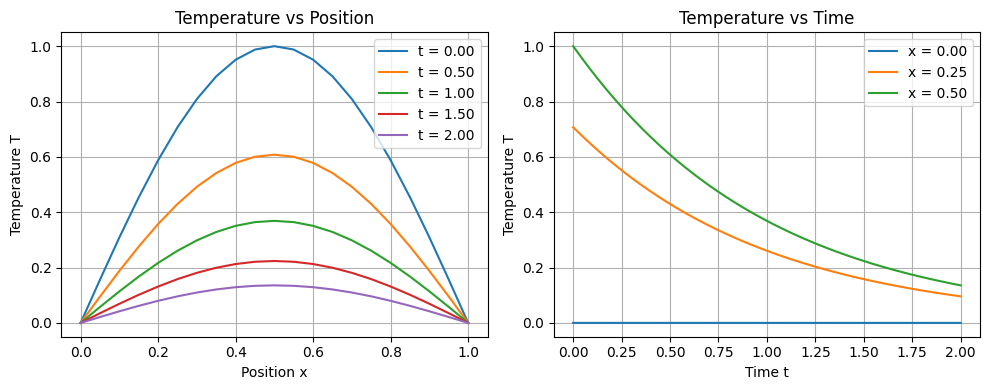

In [2]:
# --- Create side-by-side subplots ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# --- Left plot: Temperature vs position at several times ---
tind = [0, round(0.25*Nt), round(0.5*Nt), round(0.75*Nt), Nt]
for n in tind:
    axs[0].plot(x, T[:, n], label=f"t = {t[n]:.2f}")
axs[0].set_title('Temperature vs Position')
axs[0].set_xlabel('Position x')
axs[0].set_ylabel('Temperature T')
axs[0].legend()
axs[0].grid(True)

# --- Right plot: Temperature vs time at several spatial points ---
xind = [0, round(0.25*Nx), round(0.5*Nx)]
for i in xind:
    axs[1].plot(t, T[i, :], label=f"x = {x[i]:.2f}")
axs[1].set_title('Temperature vs Time')
axs[1].set_xlabel('Time t')
axs[1].set_ylabel('Temperature T')
axs[1].legend()
axs[1].grid(True)

# --- Adjust layout ---
plt.tight_layout()
plt.show()

## Animated plot

The plot below animates the temperature distribution history over time

In [12]:
# Downsample frames for smoother animation if needed
N_every = 20
frames_idx = range(0, len(t), N_every)

# --- Build Frames ---
frames = [
    go.Frame(
        data=[go.Scatter(x=x, y=T[:, j], mode="lines", line=dict(width=2))],
        name=str(j),
        layout=go.Layout(title_text=f"Temperature Evolution Over Time (t = {t[j]:.2f})")
    )
    for j in frames_idx
]

# --- Build Slider Steps ---
slider_steps = [
    {
        "args": [[str(j)], {"frame": {"duration": 0, "redraw": True},
                            "mode": "immediate"}],
        "label": f"{t[j]:.2f}",
        "method": "animate",
    }
    for j in frames_idx
]

# --- Create Figure ---
fig = go.Figure(
    data=[go.Scatter(x=x, y=T[:, 0], mode="lines", line=dict(width=2))],
    layout=go.Layout(
        width=700,    # narrower figure
        height=450,   # moderate height
        title=f"Temperature Evolution Over Time (t = {t[0]:.2f})",
        xaxis=dict(title="Grid Points (x)", range=[np.min(x), np.max(x)]),
        yaxis=dict(title="Temperature (T)", range=[np.min(T), np.max(T)]),
        updatemenus=[{
            "type": "buttons",
            "x": 0.05, "y": -0.2,
            "buttons": [
                {"label": "Play", "method": "animate",
                 "args": [None, {"frame": {"duration": 100, "redraw": True},
                                 "fromcurrent": True, "transition": {"duration": 0}}]},
                {"label": "Pause", "method": "animate",
                 "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                   "mode": "immediate"}]}
            ]
        }],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {"prefix": "Time = ", "suffix": " s", "font": {"size": 16}},
            "pad": {"t": 30},
            "len": 0.9,
            "x": 0.1,
            "y": -0.05,
            "steps": slider_steps
        }]
    ),
    frames=frames
)

fig.show()

## Code modification for flux boundary condition

To impose a flux of $q_0$ for time $t > 0$ we require

\begin{equation}
\frac{\partial T}{\partial x} = q_0 \quad\text{for}\quad t > 0
\end{equation}

Note that at $t = 0$, the flux condition is not imposed; instead, the initial condition takes precedence. <b>The flux condition "turns on" once we move past time 0.</b>

Applied at time $t_{n+1}$, a forward difference approximation to the spatial derivative gives
\begin{equation}
\frac{T_1^{n+1} - T_0^{n+1}}{\Delta x}= q_0
\end{equation}

Therefore the update rule for $T_0^{n+1}$ at every time step is
\begin{equation}
T_0^{n+1} = T_1^{n+1} - \Delta x q_0
\end{equation}

The code below is the same as the previous example except that it updates $T_0^{n+1}$ according to the formula above to impose the Neumann boundary condition during the time loop. The variable <code>q0</code> can be changed to change the boundary condition value from its default value of 0.
* <b>Important<b>: Note you must update the interior temperatures first in the time loop, since $T_0^{n+1}$ depends on $T_1^{n+1}$.

In [4]:
# Space discretization
L = 1                       # Domain end point: 0 <= x <= L
dx = 0.05                   # Spatial grid spacing
Nx = round(L/dx)            # Nx + 1 grid points
x = np.linspace(0, L, Nx+1) # Grid points

# Time discretization
tend = 2                        # Ending time
dt = 0.001                      # Time step
Nt = int(tend/dt)               # Number of steps
t = np.linspace(0, dt*Nt, Nt+1) # List of solution times

# Diffusion constant and beta
alpha = 1
beta = alpha/dx**2

# Function for source term f(x)
f = lambda x, t: (np.pi**2 - 1)*np.exp(-t)*np.sin(np.pi*x)

# Print critical Forward Euler timestep info
print('dt =     ', dt)
print('dt_max = ', 0.5*dx**2/alpha)

# Initial condition
Tinit = np.sin(np.pi*x)

# Initialize solution variable
T = np.zeros((Nx+1, Nt+1))
T[:,0] = Tinit

# Boundary conditions (assumed fixed in time)
q0 =  0  #  Flux at left end
Tright  = 0  # Fixed temperature value at the right end

# Forward Euler
for n in range(Nt):

    # Update interior nodes
    for i in range(1, Nx):
        T[i,n+1] = T[i,n] + dt*(beta*(T[i-1,n] - 2*T[i,n] + T[i+1,n]) + f(x[i], t[n]))

    # Update boundary nodes
    T[ 0, n+1] = T[1, n+1] - dx*q0 # Flux BC
    T[Nx, n+1] = Tright # Fixed BC



dt =      0.001
dt_max =  0.0012500000000000002


### Plotting

Below are commands to create
1. Plots of temperature distributions at several fixed times
2. Plots of temperature vs time for several fixed points on the grid
3. Animated plot of temperature distribution vs time

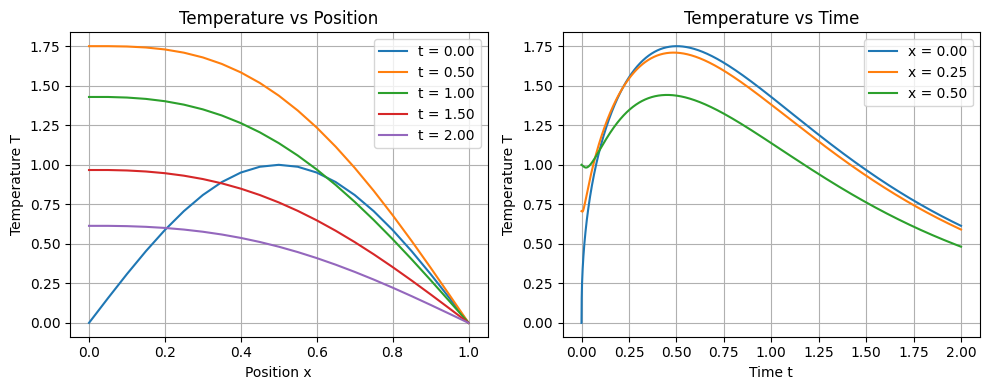

In [5]:
# --- Create side-by-side subplots ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# --- Left plot: Temperature vs position at several times ---
tind = [0, round(0.25*Nt), round(0.5*Nt), round(0.75*Nt), Nt]
for n in tind:
    axs[0].plot(x, T[:, n], label=f"t = {t[n]:.2f}")
axs[0].set_title('Temperature vs Position')
axs[0].set_xlabel('Position x')
axs[0].set_ylabel('Temperature T')
axs[0].legend()
axs[0].grid(True)

# --- Right plot: Temperature vs time at several spatial points ---
xind = [0, round(0.25*Nx), round(0.5*Nx)]
for i in xind:
    axs[1].plot(t, T[i, :], label=f"x = {x[i]:.2f}")
axs[1].set_title('Temperature vs Time')
axs[1].set_xlabel('Time t')
axs[1].set_ylabel('Temperature T')
axs[1].legend()
axs[1].grid(True)

# --- Adjust layout ---
plt.tight_layout()
plt.show()

## Animated plot

The code below animates the temperature history

In [11]:
import plotly.graph_objects as go

# Downsample frames for smoother animation if needed
N_every = 20
frames_idx = range(0, len(t), N_every)

# --- Build Frames ---
frames = [
    go.Frame(
        data=[go.Scatter(x=x, y=T[:, j], mode="lines", line=dict(width=2))],
        name=str(j),
        layout=go.Layout(title_text=f"Temperature Evolution Over Time (t = {t[j]:.2f})")
    )
    for j in frames_idx
]

# --- Build Slider Steps ---
slider_steps = [
    {
        "args": [[str(j)], {"frame": {"duration": 0, "redraw": True},
                            "mode": "immediate"}],
        "label": f"{t[j]:.2f}",
        "method": "animate",
    }
    for j in frames_idx
]

# --- Create Figure ---
fig = go.Figure(
    data=[go.Scatter(x=x, y=T[:, 0], mode="lines", line=dict(width=2))],
    layout=go.Layout(
        width=700,    # narrower figure
        height=450,   # moderate height
        title=f"Temperature Evolution Over Time (t = {t[0]:.2f})",
        xaxis=dict(title="Grid Points (x)", range=[np.min(x), np.max(x)]),
        yaxis=dict(title="Temperature (T)", range=[np.min(T), np.max(T)]),
        updatemenus=[{
            "type": "buttons",
            "x": 0.05, "y": -0.2,
            "buttons": [
                {"label": "Play", "method": "animate",
                 "args": [None, {"frame": {"duration": 100, "redraw": True},
                                 "fromcurrent": True, "transition": {"duration": 0}}]},
                {"label": "Pause", "method": "animate",
                 "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                   "mode": "immediate"}]}
            ]
        }],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {"prefix": "Time = ", "suffix": " s", "font": {"size": 16}},
            "pad": {"t": 30},
            "len": 0.9,
            "x": 0.1,
            "y": -0.05,
            "steps": slider_steps
        }]
    ),
    frames=frames
)

fig.show()